In [ ]:
!pip install mplsoccer
!pip install -U pandas
!pip install -U seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 9.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import pandas as pd
from google.colab import drive
import seaborn as sns
import networkx as nx
from mplsoccer import VerticalPitch
import numpy as np
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from mplsoccer import Pitch, football_shirt_marker, FontManager

import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

drive.mount('/content/drive')

file_paths = {
    'stories': "/content/drive/MyDrive/dataset/stories.parquet",
    'matches': "/content/drive/MyDrive/dataset/matches.parquet",
    'minutes': "/content/drive/MyDrive/dataset/minutes.parquet",
    'player_tm_values': "/content/drive/MyDrive/dataset/player_tm_values.parquet",
    'players': "/content/drive/MyDrive/dataset/players.parquet",
    'teams': "/content/drive/MyDrive/dataset/teams.parquet"
}

dataframes = {name: pd.read_parquet(path) for name, path in file_paths.items()}

columns_info = {name: df.columns.tolist() for name, df in dataframes.items()}

for name, columns in columns_info.items():
    print(f"{name.capitalize()} DataFrame columns:")
    print(columns)
    print()


Mounted at /content/drive
Stories DataFrame columns:
['player_position', 'throw_in', 'start_x', 'penalty_conceded_goal', 'penalty_foul', 'lateral_pass', 'own_goal', 'linkup_play', 'type', 'red_card', 'penalty_goal', 'kept_possession', 'xA', 'possession_free_kick', 'shot_after_corner', 'hand_pass', 'key_pass', 'game_interruption', 'head_pass', 'head_shot', 'save_with_reflex', 'assist', 'goal_kick', 'shot_assist', 'own_goal_for', 'successful', 'through_pass', 'offensive_duel', 'start_y', 'third_assist', 'recovery', 'pass_length', 'corner', 'fairplay', 'aerial_won', 'possession_transition_low', 'possession_duration', 'possession_transition_medium', 'season', 'clearance', 'progressive_pass', 'free_kick_shot', 'pass_to_final_third', 'interception', 'shot_off_target', 'acceleration', 'shot_xgot', 'short_or_medium_pass', 'match_state', 'free_kick', 'free_kick_cross', 'duel', 'take_on', 'penalty', 'aerial_duel', 'foul_suffered', 'dribble', 'shot_block', 'shot_body_part', 'stopped_progress', 'y

# Rangiranje igralcev glede na pozicijo

SEZONA 2023

In [ ]:
for name, df in dataframes.items():
    if 'season' in df.columns:
        print(f"DataFrame '{name}' vsebuje stolpec 'season'.")
        print(df['season'].unique()) 


DataFrame 'stories' vsebuje stolpec 'season'.
[2021 2022 2023]
DataFrame 'matches' vsebuje stolpec 'season'.
[2021 2022 2023]
DataFrame 'minutes' vsebuje stolpec 'season'.
[2021 2022 2023]


In [ ]:
for name in ['stories', 'matches', 'minutes']:
    df = dataframes[name]
    print(f"\nŠtevilo vrstic po sezoni v '{name}' DataFrame:")
    print(df['season'].value_counts())



Število vrstic po sezoni v 'stories' DataFrame:
season
2023    660006
2021    646496
2022    639803
Name: count, dtype: int64

Število vrstic po sezoni v 'matches' DataFrame:
season
2021    380
2022    380
2023    380
Name: count, dtype: int64

Število vrstic po sezoni v 'minutes' DataFrame:
season
2023    11384
2022    11345
2021    10474
Name: count, dtype: int64


In [ ]:
players = dataframes['players']
roles = players['role'].unique()
print(roles)

['Midfielder' 'Forward' 'Defender' 'Goalkeeper']


ANALIZA NAPADALCEV V SEZONO 2023 -  metrične vrednosti, ki sem jih uporabila: goli (število golov, število strelov v okvir vrat), napadalne akcije (ključne podaje, asistence, uspešni driblingi), streli (streli v okvir vrat, streli mimo vrat), kazenski udarci (izvedeni kazenski streli, goli iz kazenskih strelov.



Top 10 napadalcev v sezoni 2023 (z združenimi kategorijami):
     player_id     short_name  goli_contribution  \
81      520291        B. Saka                355   
15      120353  Mohamed Salah                450   
94      549485        J. Doku                110   
72      472363  D. Kulusevski                200   
10       14911  Son Heung-Min                365   
73      478618      A. Gordon                255   
38      301047     O. Watkins                415   
37      299699       J. Bowen                345   
127     692543    A. Garnacho                200   
33      286831     D. Solanke                385   

     napadalne_akcije_contribution  streli_contribution  \
81                            1070                  480   
15                             678                  561   
94                            1332                  217   
72                            1130                  267   
10                             794                  405   
73          

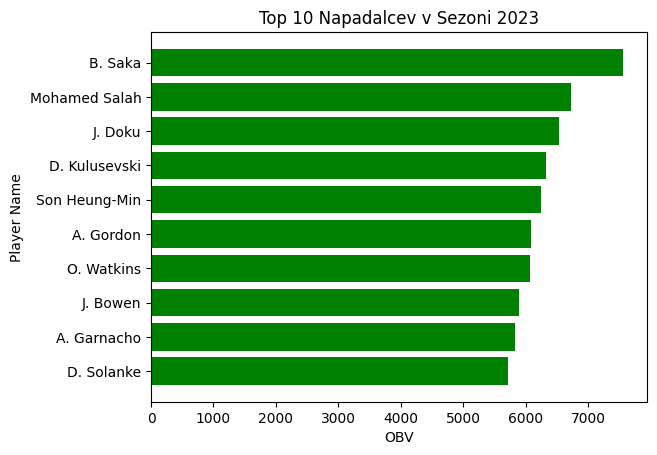

In [ ]:
stories_2023 = dataframes['stories'][dataframes['stories']['season'] == 2023]

merged = stories_2023.merge(players[['player_id', 'role', 'short_name']], on='player_id', how='left')

attackers = merged[merged['role'] == 'Forward'].copy()

stories_2023 = dataframes['stories'][dataframes['stories']['season'] == 2023]
players = dataframes['players']

merged = stories_2023.merge(players[['player_id', 'role', 'short_name']], on='player_id', how='left')

forwards = merged[merged['role'] == 'Forward'].copy()

category_weights = {
    'goli': {'goal': 10, 'shot_on_target': 5},
    'napadalne_akcije': {'key_pass': 6, 'assist': 8, 'dribble': 4},
    'streli': {'shot_off_target': 3, 'shot_on_target': 7},
    'kazenski_udarci': {'penalty': 6, 'penalty_conceded_goal': 4},
}

final_weights = {
    'goli': 5,
    'napadalne_akcije': 4,
    'streli': 3,
    'kazenski_udarci': 2,
}

category_contributions = {}

for category, metrics in category_weights.items():
    contributions = (
        forwards.groupby(['player_id', 'short_name'])[[metric for metric in metrics.keys() if metric in forwards.columns]]
        .sum()
        .reset_index()
    )
    for metric, weight in metrics.items():
        if metric in contributions:
            contributions[metric] *= weight
    contributions[f"{category}_contribution"] = contributions[[metric for metric in metrics.keys() if metric in contributions]].sum(axis=1)
    category_contributions[category] = contributions[['player_id', 'short_name', f"{category}_contribution"]]

final_scores = None
for category, df in category_contributions.items():
    if final_scores is None:
        final_scores = df
    else:
        final_scores = final_scores.merge(df, on=['player_id', 'short_name'], how='outer')

final_scores['obv'] = sum(
    final_scores[f"{category}_contribution"] * weight for category, weight in final_weights.items()
)

final_scores = final_scores.sort_values(by='obv', ascending=False)

top_attackers = final_scores.head(10)
print("Top 10 napadalcev v sezoni 2023 (z združenimi kategorijami):")
print(top_attackers)

plt.barh(top_attackers['short_name'], top_attackers['obv'], color="green")
plt.xlabel("OBV")
plt.ylabel("Player Name")
plt.title("Top 10 Napadalcev v Sezoni 2023")
plt.gca().invert_yaxis()
plt.show()



ANALIZA VRATARJEV V SEZONI 2023 - Metrične vrednosti, ki sem jih uporabila: obrambe (število obranjenih strelov, število obranjenih kazenskih strelov, število obranjenih strelov z refleksom), preprečevanje golov (število prejetih golov, število prejetih golov iz kazenskih strelov), upravljanje igre (število uspešnih izhodov iz kazenskega prostora, število progresivnih podaj), obramba visokih žog (število uspešno osvojenih visokih žog v zraku, število izbijanj žoge iz nevarnega območja).

Top 10 golmanov v sezoni 2023 (z združenimi kategorijami):
    player_id      short_name  obrambe_contribution  \
17      38659     T. Kaminski                  1113   
31     344038        A. Onana                  1062   
5       10131     J. Pickford                   887   
3        9210  W. Foderingham                   923   
10      14768         B. Leno                   971   
23     219526      M. Flekken                   763   
24     227085         José Sá                   971   
40     560137     J. Trafford                   741   
15      25418       A. Aréola                   988   
14      20922            Neto                   729   

    preprečevanje_golov_contribution  upravljanje_igre_contribution  \
17                              -526                           2015   
31                              -376                           1797   
5                               -338                           2297   
3                               -494               

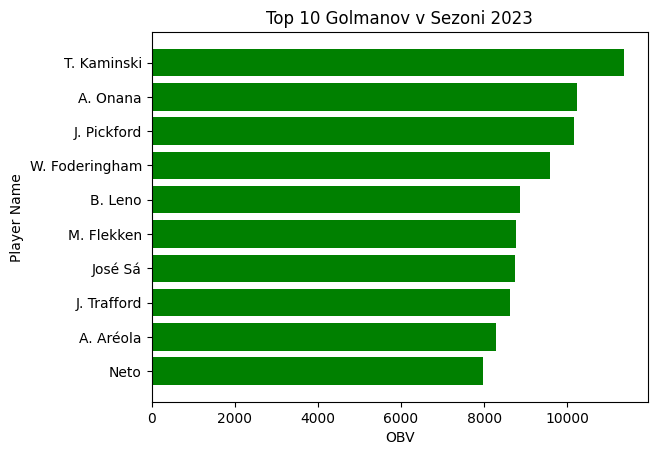

In [ ]:
import matplotlib.pyplot as plt

stories_2023 = dataframes['stories'][dataframes['stories']['season'] == 2023]
players = dataframes['players']

merged = stories_2023.merge(players[['player_id', 'role', 'short_name']], on='player_id', how='left')

goalkeepers = merged[merged['role'] == 'Goalkeeper'].copy()

category_weights = {
    'obrambe': {'save': 5, 'penalty_save': 4, 'save_with_reflex': 3},
    'preprečevanje_golov': {'conceded_goal': -6, 'penalty_conceded_goal': -4},
    'upravljanje_igre': {'goalkeeper_exit': 6, 'progressive_pass': 5},
    'obramba_visokih_zog': {'aerial_won': 6, 'clearance': 5}
}

final_weights = {
    'obrambe': 5,
    'preprečevanje_golov': -3,
    'upravljanje_igre': 2,
    'obramba_visokih_zog': 2
}

category_contributions = {}

for category, metrics in category_weights.items():
    contributions = (
        goalkeepers.groupby(['player_id', 'short_name'])[[metric for metric in metrics.keys() if metric in goalkeepers.columns]]
        .sum()
        .reset_index()
    )
    for metric, weight in metrics.items():
        if metric in contributions:
            contributions[metric] *= weight
    contributions[f"{category}_contribution"] = contributions[[metric for metric in metrics.keys() if metric in contributions]].sum(axis=1)
    category_contributions[category] = contributions[['player_id', 'short_name', f"{category}_contribution"]]

final_scores = None
for category, df in category_contributions.items():
    if final_scores is None:
        final_scores = df
    else:
        final_scores = final_scores.merge(df, on=['player_id', 'short_name'], how='outer')

final_scores['obv'] = sum(
    final_scores[f"{category}_contribution"] * weight for category, weight in final_weights.items()
)

final_scores = final_scores.sort_values(by='obv', ascending=False)

top_goalkeepers = final_scores.head(10)
print("Top 10 golmanov v sezoni 2023 (z združenimi kategorijami):")
print(top_goalkeepers)

plt.barh(top_goalkeepers['short_name'], top_goalkeepers['obv'], color="green")
plt.xlabel("OBV")
plt.ylabel("Player Name")
plt.title("Top 10 Golmanov v Sezoni 2023")
plt.gca().invert_yaxis()
plt.show()


ANALIZA VEZISTOV V SEZONI 2023 - Metrične vrednosti, ki sem jih uporabila: kreacija igre (ključne podaje, asistence, prodorne podaje), obrambne akcije (prestrezanja, izbijanja, uspešni odvzemi žoge), posedovanje žoge (goli iz posesti, napadalne akcije iz posesti, pričakovani goli iz posesti), preigravanja in napadalne akcije (uspešni driblingi, preigravanja, progresivne podaje), kazenski udarci (izvedeni kazenski streli, prejeti goli iz kazenskih strelov, prekrški, ki so jih vezisti utrpeli).

Top 10 vezistov v sezoni 2023 (z združenimi kategorijami):
     player_id       short_name  kreacija_igre_contribution  \
76      364860            Rodri                         237   
20       15526          P. Groß                         250   
46      243588  Bruno Fernandes                         393   
63      302292      M. Ødegaard                         401   
81      370937  Bruno Guimarães                         357   
83      379209          D. Rice                         114   
53      265673   Bernardo Silva                         211   
99      447205         P. Foden                         198   
101     447358     C. Gallagher                          96   
116     481911  A. Mac Allister                         219   

     obrambne_akcije_contribution  posedovanje_zoge_contribution  \
76                            611                   11086.804398   
20                            488                    8403.125595   
46                            591          

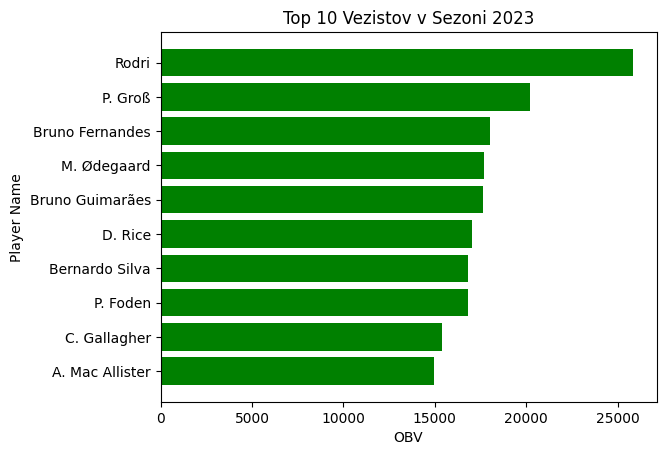

In [ ]:
stories_2023 = dataframes['stories'][dataframes['stories']['season'] == 2023]
players = dataframes['players']

merged = stories_2023.merge(players[['player_id', 'role', 'short_name']], on='player_id', how='left')

midfielders = merged[merged['role'] == 'Midfielder'].copy()

category_weights = {
    'kreacija_igre': {'key_pass': 4, 'assist': 3, 'through_pass': 3},
    'obrambne_akcije': {'interception': 4, 'clearance': 3, 'tackle': 3},
    'posedovanje_zoge': {'possession_goal': 5, 'possession_attack': 3, 'possession_xg': 2},
    'preigravanja_napadalne_akcije': {'dribble': 4, 'take_on': 3, 'progressive_pass': 3},
    'kazenski_udarci': {'penalty': 4, 'penalty_conceded_goal': 4, 'foul_suffered': 2}
}

final_weights = {
    'kreacija_igre': 4,
    'obrambne_akcije': 2,
    'posedovanje_zoge': 2,
    'preigravanja_napadalne_akcije': 1,
    'kazenski_udarci': 1
}

category_contributions = {}

for category, metrics in category_weights.items():
    contributions = (
        midfielders.groupby(['player_id', 'short_name'])[[metric for metric in metrics.keys() if metric in midfielders.columns]]
        .sum()
        .reset_index()
    )
    for metric, weight in metrics.items():
        if metric in contributions:
            contributions[metric] *= weight
    contributions[f"{category}_contribution"] = contributions[[metric for metric in metrics.keys() if metric in contributions]].sum(axis=1)
    category_contributions[category] = contributions[['player_id', 'short_name', f"{category}_contribution"]]

final_scores = None
for category, df in category_contributions.items():
    if final_scores is None:
        final_scores = df
    else:
        final_scores = final_scores.merge(df, on=['player_id', 'short_name'], how='outer')

final_scores['obv'] = sum(
    final_scores[f"{category}_contribution"] * weight for category, weight in final_weights.items()
)

final_scores = final_scores.sort_values(by='obv', ascending=False)

top_midfielders = final_scores.head(10)
print("Top 10 vezistov v sezoni 2023 (z združenimi kategorijami):")
print(top_midfielders)

plt.barh(top_midfielders['short_name'], top_midfielders['obv'], color="green")
plt.xlabel("OBV")
plt.ylabel("Player Name")
plt.title("Top 10 Vezistov v Sezoni 2023")
plt.gca().invert_yaxis()
plt.show()


ANALIZA BRANILCEV V SEZONI 2023 - Metrične vrednosti, ki sem jih uporabila: obrambe (prestrezanja, izbijanja, uspešni odvzemi žoge), blokiranje strelov (blokirani streli, blokirani streli z deli telesa, čiščenje z glavo), napredovanje (progresivne podaje, podaje v zadnjo tretjino, dolge podaje), prekrški in kartoni (utrpljeni prekrški, rumeni kartoni, rdeči kartoni).

Top 10 obrambnih igralcev v sezoni 2023 (z združenimi kategorijami):
     player_id     short_name  obrambe_contribution  \
192     901432    Joe Johnson                901437   
191     822917  J. Acheampong                822927   
190     750677      A. Murphy                750687   
189     744143      F. Munroe                744143   
188     698930       K. Casey                698930   
187     697957    W. Kambwala                698090   
186     685308   A. Gilchrist                685408   
185     658798       R. Lewis                658916   
184     656446      M. Kerkez                657033   
183     647329    L. Assignon                647677   

     blokiranje_streli_contribution  napredovanje_contribution  \
192                          901432                     901472   
191                          822917                     822922   
190                          750677                     750685   
189                          744143                     74414

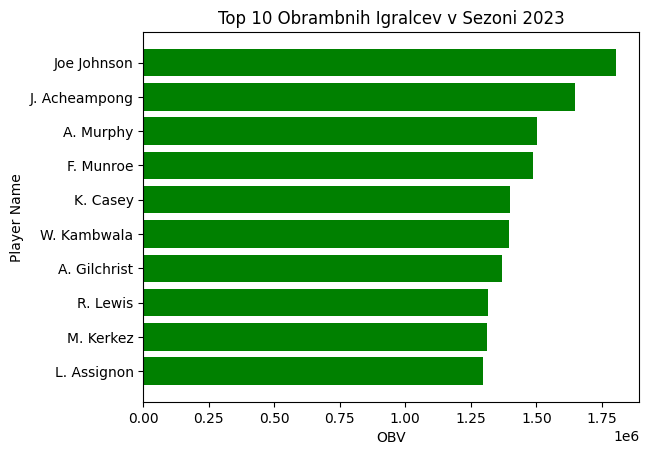

In [ ]:
import matplotlib.pyplot as plt

stories_2023 = dataframes['stories'][dataframes['stories']['season'] == 2023]
players = dataframes['players']

merged = stories_2023.merge(players[['player_id', 'role', 'short_name']], on='player_id', how='left')

defenders = merged[merged['role'] == 'Defender'].copy()

category_weights = {
    'obrambe': {'interception': 5, 'clearance': 3, 'tackle': 2},
    'blokiranje_streli': {'shot_blocked': 5, 'shot_body_part': 2, 'clear_header': 3},
    'napredovanje': {'progressive_pass': 4, 'pass_to_final_third': 2, 'long_pass': 3},
    'prekrški_in_kartoni': {'foul_suffered': 3, 'yellow_card': 3, 'red_card': 4},
}

final_weights = {
    'obrambe': 4,
    'blokiranje_streli': 3,
    'napredovanje': -2,
    'prekrški_in_kartoni': -3,
}

category_contributions = {}

for category, metrics in category_weights.items():
    contributions = (
        defenders.groupby(['player_id', 'short_name'])[[metric for metric in metrics.keys() if metric in defenders.columns]]
        .sum()
        .reset_index()
    )

    for metric, weight in metrics.items():
        if metric in contributions.columns:
            contributions[metric] *= weight

    numeric_columns = [col for col in contributions.columns if pd.api.types.is_numeric_dtype(contributions[col])]
    contributions[f"{category}_contribution"] = contributions[numeric_columns].sum(axis=1)

    category_contributions[category] = contributions[['player_id', 'short_name', f"{category}_contribution"]]
final_scores = category_contributions['obrambe']
for category, df in category_contributions.items():
    if category != 'obrambe':
        final_scores = final_scores.merge(df, on=['player_id', 'short_name'], how='outer')


final_scores['obv'] = sum(
    final_scores[f"{category}_contribution"] * final_weights.get(category, 0) for category in category_weights.keys()
)

final_scores = final_scores.sort_values(by='obv', ascending=False)

top_defenders = final_scores.head(10)
print("Top 10 obrambnih igralcev v sezoni 2023 (z združenimi kategorijami):")
print(top_defenders)

plt.barh(top_defenders['short_name'], top_defenders['obv'], color="green")
plt.xlabel("OBV")
plt.ylabel("Player Name")
plt.title("Top 10 Obrambnih Igralcev v Sezoni 2023")
plt.gca().invert_yaxis()
plt.show()


# Analiza posameznega igralca v sezoni 2023


Uporabila sem naslednje metrične vrednosti: angle,length,progressive_run,start_y,start_x,shot_xg, pass_recipient_id, player_id,team_name,short_name,end_y,end_x

In [ ]:
player_id = 692543
igraEnega = stories_2023[stories_2023['player_id'] == player_id]
podatki = pd.merge(dataframes['matches'], dataframes['minutes'], on='match_id', how='left')
podatki = pd.merge(podatki, players, on='player_id', how='left')
podatki = pd.merge(podatki, dataframes['player_tm_values'], how='left', on='player_id')
podatki = pd.merge(podatki, dataframes['teams'], how='left', on='team_id')
igraEnega = igraEnega.copy()
igraEnega['start_x'] = igraEnega['start_x'] * 1.2
igraEnega['end_x'] = igraEnega['end_x'] * 1.2
igraEnega['start_y'] = igraEnega['start_y'] * 0.8
igraEnega['end_y'] = igraEnega['end_y'] * 0.8

In [ ]:
stories_2023

,player_position,throw_in,start_x,penalty_conceded_goal,penalty_foul,lateral_pass,own_goal,linkup_play,type,red_card,penalty_goal,kept_possession,xA,possession_free_kick,shot_after_corner,hand_pass,key_pass,game_interruption,head_pass,head_shot,save_with_reflex,assist,goal_kick,shot_assist,own_goal_for,successful,through_pass,offensive_duel,start_y,third_assist,recovery,pass_length,corner,fairplay,aerial_won,possession_transition_low,possession_duration,possession_transition_medium,season,clearance,progressive_pass,free_kick_shot,pass_to_final_third,interception,shot_off_target,acceleration,shot_xgot,short_or_medium_pass,match_state,free_kick,free_kick_cross,duel,take_on,penalty,aerial_duel,foul_suffered,dribble,shot_block,shot_body_part,stopped_progress,yellow_card,shot_on_target,carry,long_pass,competition,possession_throw_in,foul,end_y,smart_pass,back_pass,sliding_tackle,loss,end_x,defensive_duel,goalkeeper_exit,player_id,goal,pass_to_penalty_area,id,possession_xg,whistle,minute,shot_after_throw_in,shot_after_free_kick,second_assist,progressed_with_ball,forward_pass,possession_goal,period,dribbled_past_attempt,counterpressing_recovery,team_id,touch_in_box,deep_completion,touch,ground_duel,shot,offside,cross,shot_against_gkid,possession_counterattack,possession_free_kick_cross,save,shot_xg,shot_blocked,possession_penalty,ball_out,pass_low,under_pressure,second,cross_blocked,possession_direct_free_kick,possession_team_id,shot_on_post,shot_against,possession_corner,duel_opponent_id,progressive_run,event_index,clear_header,pass_recipient_id,recovered_possession,pass_high,deep_completed_cross,possession_transition_high,loose_ball_duel,penalty_save,infraction,shot_goal_zone,conceded_goal,is_pass,possession_attack,pass_blocked,opportunity,possession_id,shot_id,possession_set_piece_attack
1286299,RCMF,False,49,False,False,False,False,False,pass,False,False,False,0.0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,53,False,False,13,False,False,False,False,39.114765,False,2023,False,False,False,False,False,False,False,0.0,True,0,False,False,False,False,False,False,False,False,False,,False,False,False,False,False,364,False,False,52,False,True,False,False,37,False,False,243588,False,False,1716086909,0.0000,False,0,False,False,False,False,False,False,1,False,False,1611,False,False,False,False,False,False,False,-1,False,False,False,0.00000,False,False,False,False,False,2,False,False,1611,False,False,False,-1,False,0,False,40756,False,False,False,False,False,False,False,None,False,True,False,False,False,1716086909,0,False
1286300,DMF,False,37,False,False,True,False,False,pass,False,False,False,0.0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,52,False,False,21,False,False,False,False,39.114765,False,2023,False,False,False,False,False,False,False,0.0,True,0,False,False,False,False,False,False,False,False,False,,False,False,False,False,False,364,False,False,21,False,False,False,False,37,False,False,40756,False,False,1716086910,0.0000,False,0,False,False,False,False,False,False,1,False,False,1611,False,False,False,False,False,False,False,-1,False,False,False,0.00000,False,False,False,False,False,4,False,False,1611,False,False,False,-1,False,1,False,8135,False,False,False,False,False,False,False,None,False,True,False,False,False,1716086909,0,False
1286301,LB,False,37,False,False,True,False,False,pass,False,False,False,0.0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,21,False,False,16,False,False,False,False,39.114765,False,2023,False,False,False,False,False,False,False,0.0,True,0,False,False,False,False,False,False,False,False,False,,False,False,False,False,False,364,False,False,39,False,False,False,False,27,False,False,8135,False,False,1716086911,0.0000,False,0,False,False,False,False,False,False,1,False,False,1611,False,False,False,False,False,False,False,-1,False,False,False,0.00000,False,False,False,False,False,5

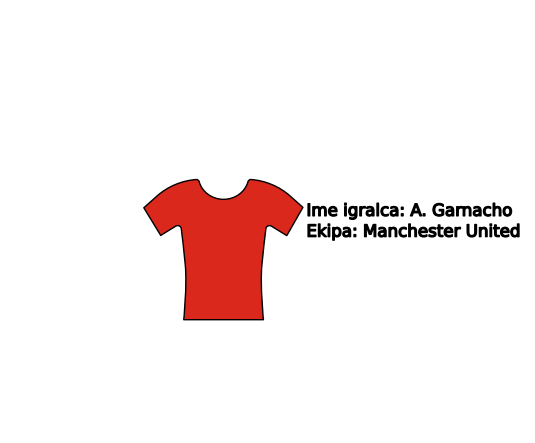

In [ ]:
def draw_jersey(player_id, podatki):
    player_info = podatki[podatki['player_id'] == player_id]
    if not player_info.empty:
        short_name = player_info['short_name_x'].values[0]
        team_name = player_info['team_name'].mode()[0]
        player_text = f"Ime igralca: {short_name}\nEkipa: {team_name} "
    else:
        player_text = "Ni tega idja."
    fig, ax = plt.subplots(figsize=(8, 5.5))
    pitch = Pitch()
    pitch.scatter(0.5, 0.5, marker=football_shirt_marker, s=20000,
                  ec='black', fc='#DA291C', ax=ax)
    ax.text(0.7, 0.5, player_text, fontsize=12, ha='left', va='center', color='black',
            path_effects=[path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.show()
draw_jersey(player_id, podatki)

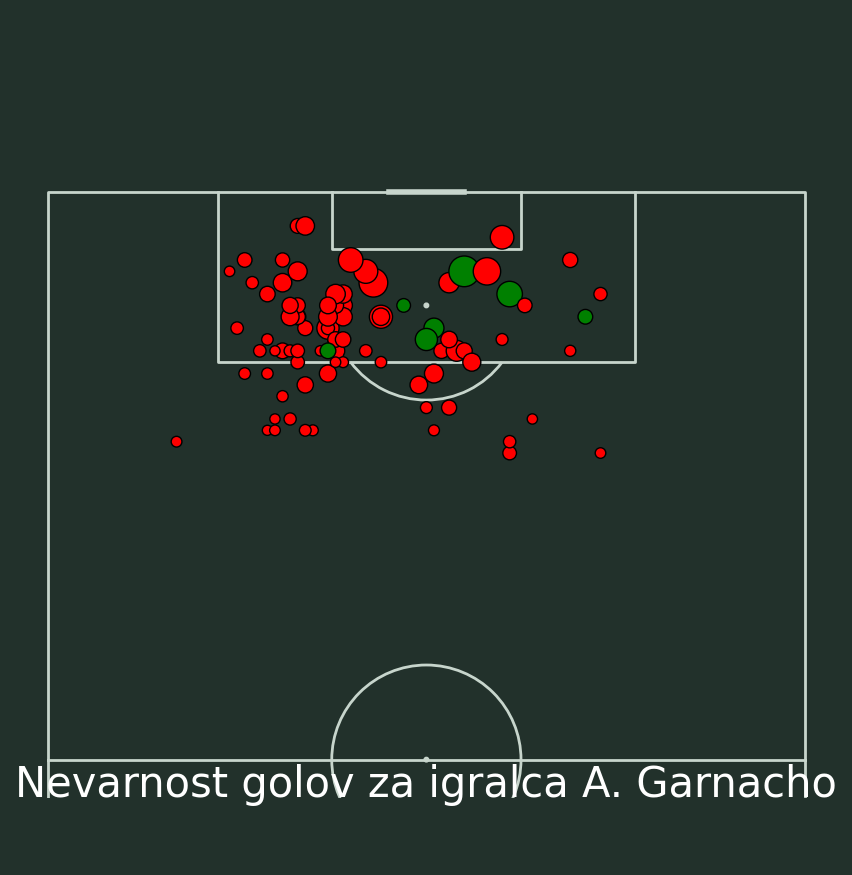

In [ ]:
G = nx.DiGraph()
player_passes = igraEnega[(igraEnega['type'] == 'pass')]
for _, row in player_passes.iterrows():
    recipient = row['pass_recipient_id']
    if recipient != -1:
        if G.has_edge(row['player_id'], recipient):
            G[row['player_id']][recipient]['weight'] += 1
        else:
            G.add_edge(row['player_id'], recipient, weight=1)
def get_player_name(player_id, podatki):
    player_info = podatki[podatki['player_id'] == player_id]
    if not player_info.empty:
        short_name = player_info['short_name_x'].values[0]
        return short_name
    else:
        return str(player_id)

player_names = {player_id: get_player_name(player_id, podatki) for player_id in G.nodes}

pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc', half=True)
fig, axs = pitch.grid(axis=False)
fig.set_facecolor('#22312b')
plt.title(f"Nevarnost golov za igralca {player_names[player_passes['player_id'].iloc[0]]}", fontsize=30, color='white')

player_shots = igraEnega[(igraEnega['type'] == 'shot')]
min_size = 50
size = player_shots['shot_xg'] * 800
size = size + min_size
scatter = pitch.scatter(player_shots['start_x'], player_shots['start_y'], s=size, c=['green' if goal else 'red' for goal in player_shots['goal']],alpha=1, edgecolors="black", zorder=2, label="Strel", ax=axs['pitch'])
plt.show()

Večji krogi predstavljajo strele z višjo verjetnostjo zadetka, barve pa označujejo uspešnost.

Nevarnost je prikazana na podlagi xG.


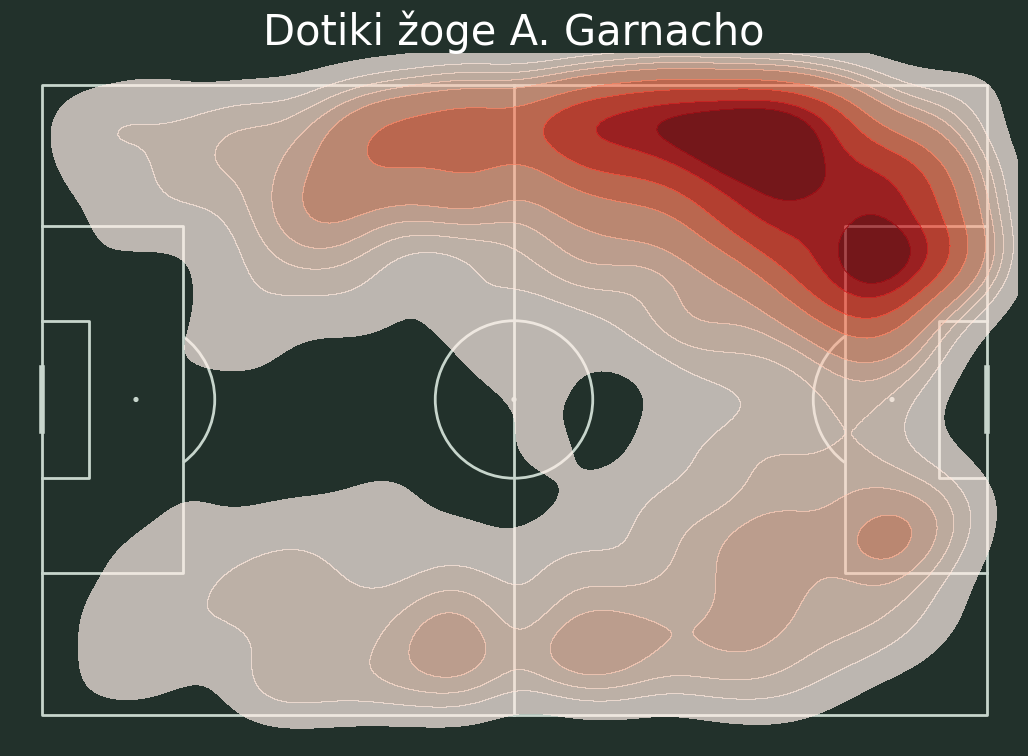

In [ ]:
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(14, 9), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#22312b')
plt.title(f"Dotiki žoge {player_names[player_passes['player_id'].iloc[0]]}", fontsize=30, color='white')
sns.kdeplot(
    data=igraEnega, x='start_x', y='start_y',
    fill=True, cmap="Reds", alpha=0.7, ax=ax, bw_adjust=0.6
)
plt.show()

**Dotiki** **žoge**

Prikazuje, na katerih delih igrišča je igralec najpogosteje imel dotik z žogo. Iz tega lahko izberemo dele igrišča, kjer je igralecc najbolj aktiven.


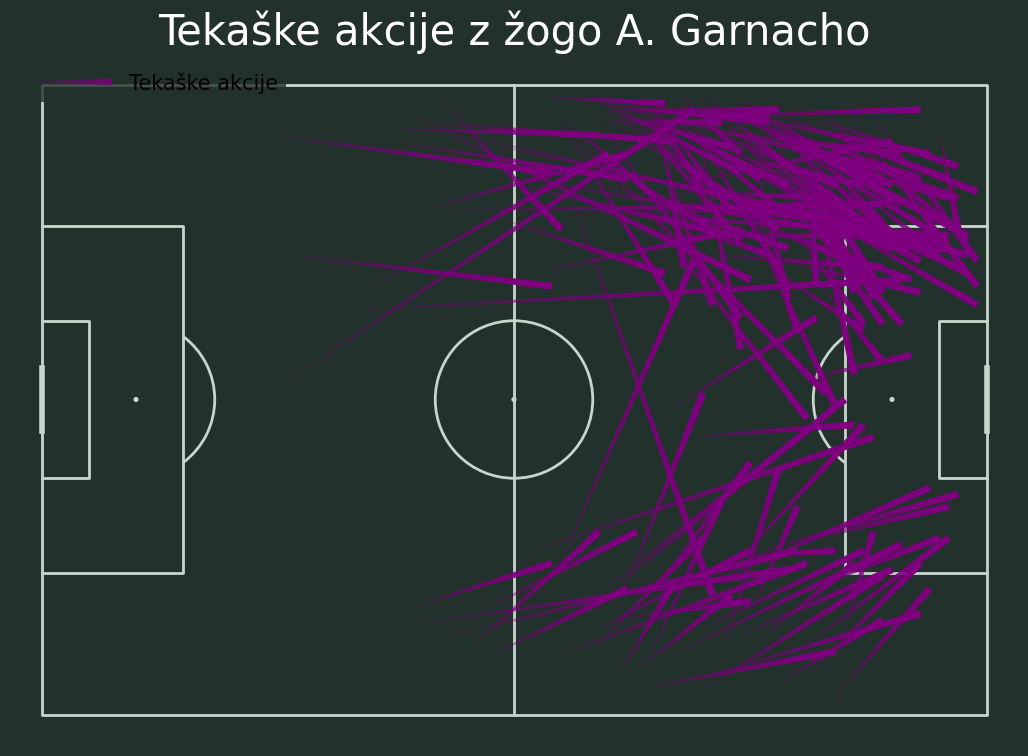

In [ ]:
progressive_mask = igraEnega['progressive_run']
progressive_runs = igraEnega[progressive_mask]
start_x = progressive_runs['start_x']
start_y = progressive_runs['start_y']
end_x = progressive_runs['end_x']
end_y = progressive_runs['end_y']
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(14, 9), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#22312b')
pitch.lines(start_x, start_y, end_x, end_y, lw=5, transparent=True, comet=True, color='purple', ax=ax, label='Tekaške akcije')
plt.title(f"Tekaške akcije z žogo {player_names[player_passes['player_id'].iloc[0]]}", fontsize=30, color='white')
ax.legend(loc='upper left', fontsize=15, facecolor='#22312b', edgecolor='None', handlelength=4)
plt.show()

**Tekaške akcije z žogo**

 Prikazuje igralčeve napredne tekaške akcije z žogo, pri katerih je žogo premaknil naprej za znatno razdaljo.

 Prikazuje, kako pogosto in učinkovito igralec premika žogo naprej.


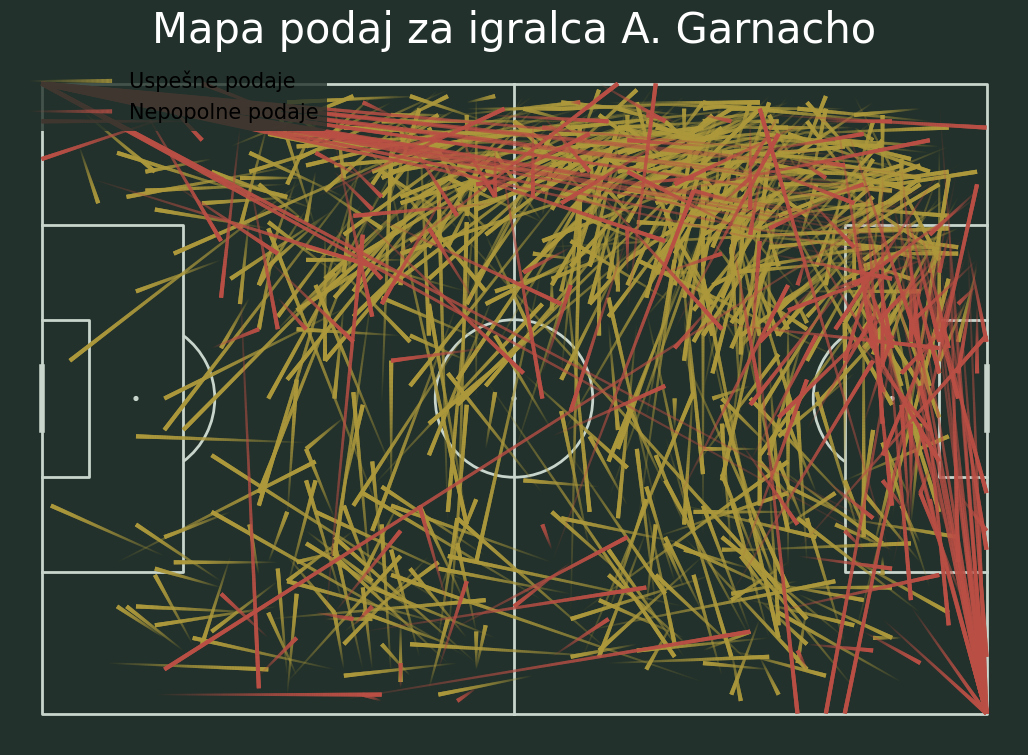

In [ ]:
pass_mask = igraEnega['type'] == 'pass'
df_pass = igraEnega[pass_mask]
start_x = df_pass['start_x']
start_y = df_pass['start_y']
end_x = df_pass['end_x']
end_y = df_pass['end_y']
completed = df_pass['successful']
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(14, 9), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#22312b')
pitch.lines(start_x[completed], start_y[completed],
            end_x[completed], end_y[completed],
            lw=3, transparent=True, comet=True, color='#ad993c', ax=ax, label='Uspešne podaje')
pitch.lines(start_x[~completed], start_y[~completed],
            end_x[~completed], end_y[~completed],
            lw=3, transparent=True, comet=True, color='#ba4f45', ax=ax, label='Nepopolne podaje')
ax.legend(loc='upper left', fontsize=15, facecolor='#22312b', edgecolor='None', handlelength=4)
plt.title(f"Mapa podaj za igralca {player_names[player_passes['player_id'].iloc[0]]}", fontsize=30, color='white')
plt.show()

Ponuja vpogled v igralčevo dejavnost, natančnost in ključna območja učinkovitosti.

Pomaga pri analizi njegove vloge in izboljšanju strategije ekipe.

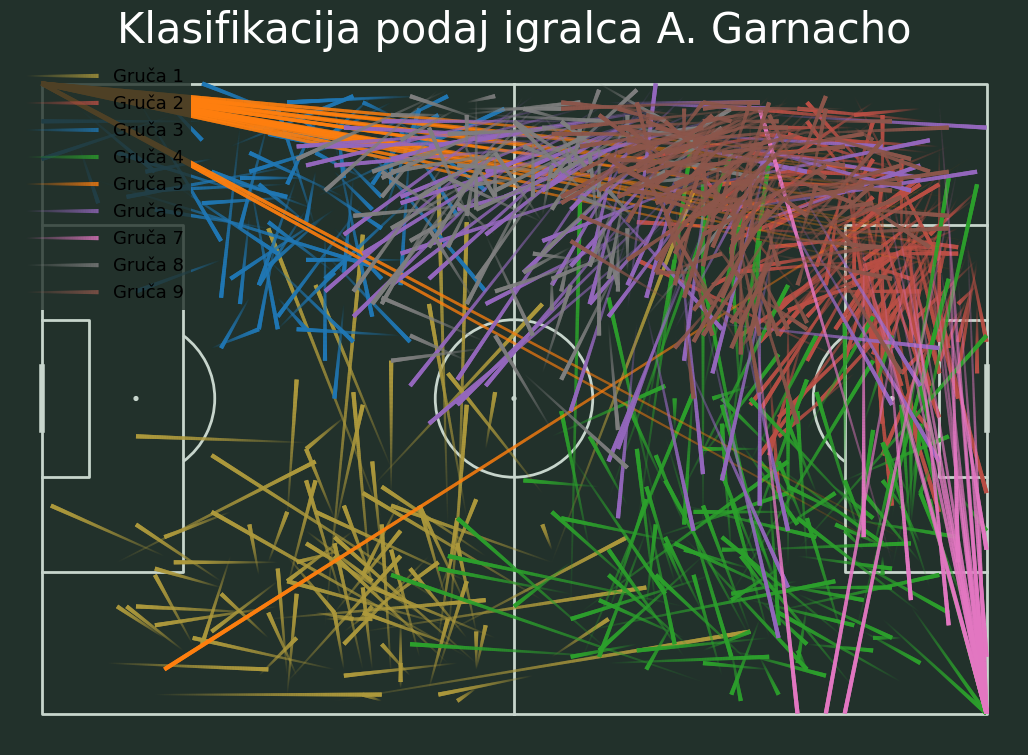

In [ ]:
pass_mask = igraEnega['type'] == 'pass'
df_pass = igraEnega[pass_mask].copy()
df_pass['length'] = np.sqrt((df_pass['end_x'] - df_pass['start_x'])**2 + (df_pass['end_y'] - df_pass['start_y'])**2)
df_pass['angle'] = np.arctan2(df_pass['end_y'] - df_pass['start_y'], df_pass['end_x'] - df_pass['start_x'])
features = df_pass[['start_x', 'start_y', 'length', 'angle']]
kmeans = KMeans(n_clusters=10, random_state=42)
df_pass['cluster'] = kmeans.fit_predict(features)
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(14, 9), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#22312b')
cluster_colors = ['#ad993c', '#ba4f45', '#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#e377c2', '#7f7f7f', '#8c564b']
for cluster_id, color in enumerate(cluster_colors):
    cluster_data = df_pass[df_pass['cluster'] == cluster_id]
    pitch.lines(cluster_data['start_x'], cluster_data['start_y'],cluster_data['end_x'], cluster_data['end_y'],lw=3, transparent=True, comet=True, color=color, ax=ax, label=f'Gruča {cluster_id + 1}')
ax.legend(loc='upper left', fontsize=13, facecolor='#22312b', edgecolor='None', handlelength=4)
plt.title(f"Klasifikacija podaj igralca {player_names[player_passes['player_id'].iloc[0]]}", fontsize=30, color='white')
plt.show()

Prikazuje klasifikacijo podaj igralca. Podaje so razvrščene v gruče glede na značilnosti (smer, razdalja in končna lokacija).
Barvne črte označujejo različne tipe podaj.
Prikazuje raznolikost so podaj izbranega igralca.

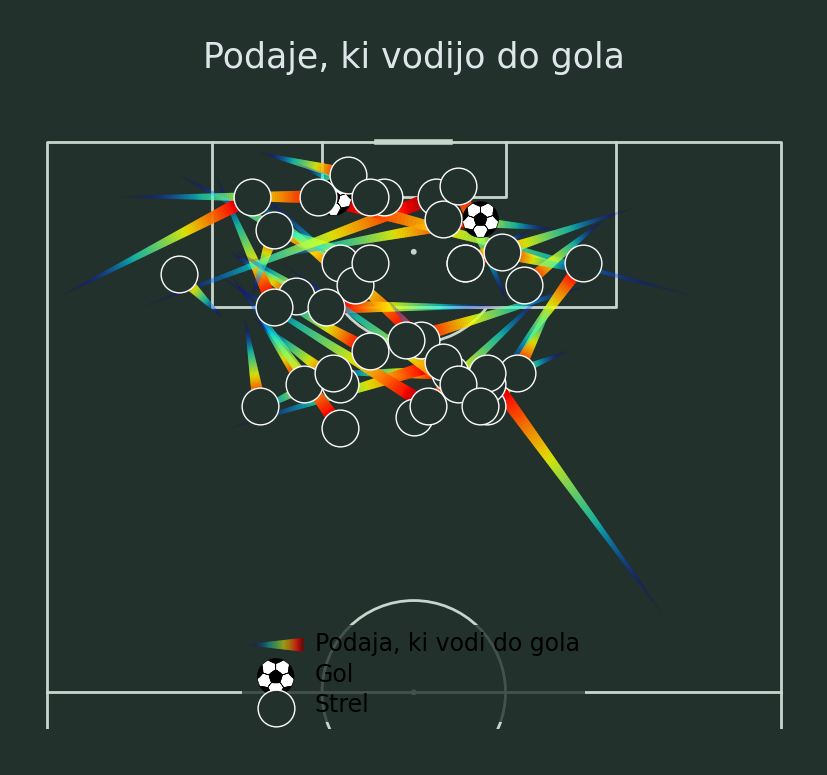

In [ ]:
shot_or_goal_passes = igraEnega[(igraEnega['shot_assist'] == True) | (igraEnega['assist'] == True)]
start_x = shot_or_goal_passes['start_x']
start_y = shot_or_goal_passes['start_y']
end_x = shot_or_goal_passes['end_x']
end_y = shot_or_goal_passes['end_y']
assist = shot_or_goal_passes['assist']
pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc', half=True)

fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0, figheight=12, title_height=0.08, title_space=0, axis=False, grid_height=0.52)
fig.set_facecolor('#22312b')
pitch.lines(start_x, start_y, end_x, end_y, lw=10, transparent=True, comet=True, cmap='jet', label='Podaja, ki vodi do gola', ax=axs['pitch'])
mask_goal = shot_or_goal_passes['assist'] == True
pitch.scatter(end_x[mask_goal], end_y[mask_goal], s=700,marker='football', edgecolors='black', c='white', zorder=2,label='Gol', ax=axs['pitch'])
pitch.scatter(end_x[~mask_goal], end_y[~mask_goal],edgecolors='white', c='#22312b', s=700, zorder=2, label='Strel', ax=axs['pitch'])
axs['title'].text(0.5, 0.5, 'Podaje, ki vodijo do gola', color='#dee6ea', va='center', ha='center',fontsize=25)
legend = axs['pitch'].legend(facecolor='#22312b', edgecolor='None', loc='lower center', handlelength=4)
for text in legend.get_texts():
    text.set_fontsize(17)
plt.show()

Graf prikazuje vse podaje igralca, ki so vodile do gola.

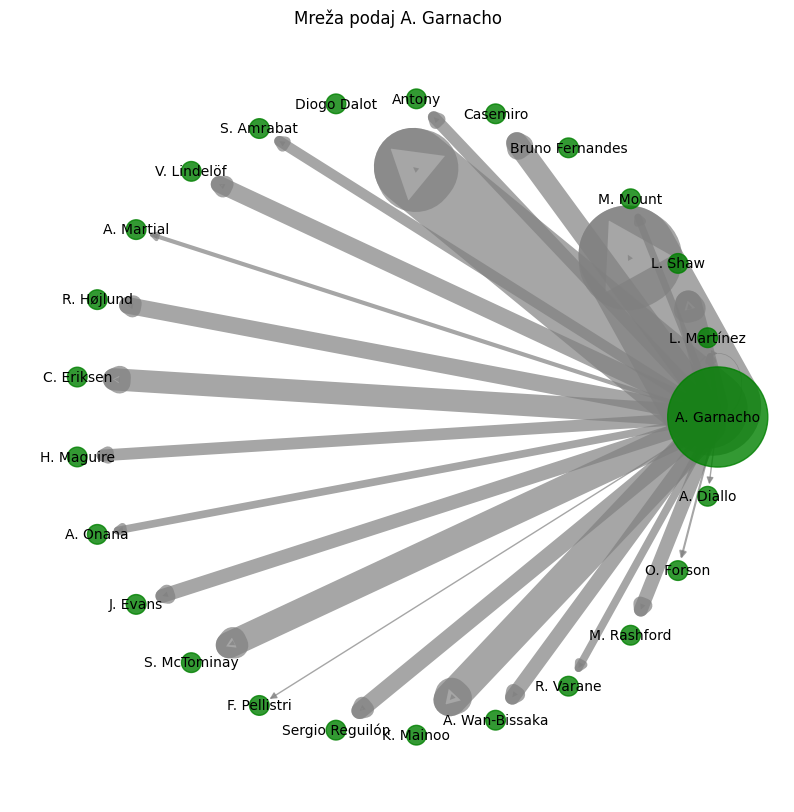

In [ ]:
player_passes = igraEnega[(igraEnega['type'] == 'pass')]
G = nx.DiGraph()
for _, row in player_passes.iterrows():
    recipient = row['pass_recipient_id']
    if recipient != -1 :
        if G.has_edge(row['player_id'], recipient):
            G[row['player_id']][recipient]['weight'] += 1
        else:
            G.add_edge(row['player_id'], recipient, weight=1)
weights = [G[u][v]['weight'] for u, v in G.edges]
node_sizes = [G.degree(n) * 200 for n in G.nodes]
def get_player_name(player_id, podatki):
    player_info = podatki[podatki['player_id'] == player_id]
    if not player_info.empty:
        short_name = player_info['short_name_x'].values[0]
        return short_name
    else:
        return str(player_id)
player_names = {player_id: get_player_name(player_id, podatki) for player_id in G.nodes}
pos = nx.circular_layout(G)
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='green', alpha=0.8)
nx.draw_networkx_edges(G, pos, width=[w * 0.5 for w in weights], alpha=0.7, edge_color='gray')
nx.draw_networkx_labels(G, pos, labels=player_names, font_size=10, font_color='black')
plt.title(f"Mreža podaj {player_names[player_passes['player_id'].iloc[0]]}")
plt.axis("off")
plt.show()

**Mreža podaj za igralca**

Debelejša črta prikazuje večjo število podaj med igralcema.


#Napovedovanje rezultatov in simulacija


Metrične vrednosti, ki sem jih uporabila:
- match_id
- team_id
- shot_xg: Daje vpogled v napadalno učinkovitost ekip
- goal: Ponuja končni rezultat tekem za analizo in modeliranje
- home_team_id, away_team_id: Ločuje domače in gostujoče ekipe
- home_team_name, away_team_name: Omogoča interpretacijo rezultatov z imeni ekip

In [ ]:
matches = dataframes['matches']
stories = dataframes['stories']
minutes = dataframes['minutes']

match_events = matches.merge(stories, on='match_id', how='inner')

team_stats = match_events.groupby(['match_id', 'team_id']).agg({
    'shot_xg': 'sum',
    'goal': 'sum'
}).reset_index()

team_stats = team_stats.merge(matches, on='match_id')

home_stats = team_stats[team_stats['team_id'] == team_stats['home_team_id']]
away_stats = team_stats[team_stats['team_id'] == team_stats['away_team_id']]

model_data = pd.DataFrame({
    'home_team': home_stats['home_team_id'],
    'away_team': away_stats['away_team_id'],
    'home_goals': home_stats['goal'],
    'away_goals': away_stats['goal']
})

avg_home_goals = model_data.groupby('home_team')['home_goals'].mean()
avg_away_goals = model_data.groupby('away_team')['away_goals'].mean()

model_data['home_team'] = model_data['home_team'].fillna(method='ffill').fillna(method='bfill').fillna(model_data['home_team'].mode()[0])
model_data['away_team'] = model_data['away_team'].fillna(method='bfill').fillna(method='ffill').fillna(model_data['away_team'].mode()[0])

model_data['home_goals'] = model_data.apply(
     lambda row: avg_home_goals[row['home_team']] if pd.isnull(row['home_goals']) else row['home_goals'], axis=1
)
model_data['away_goals'] = model_data.apply(
    lambda row: avg_away_goals[row['away_team']] if pd.isnull(row['away_goals']) else row['away_goals'], axis=1
)

team_name_mapping = pd.concat([
    home_stats[['home_team_id', 'home_team_name']].rename(columns={'home_team_id': 'team_id', 'home_team_name': 'team_name'}),
    home_stats[['away_team_id', 'away_team_name']].rename(columns={'away_team_id': 'team_id', 'away_team_name': 'team_name'})
]).drop_duplicates()

team_name_dict = team_name_mapping.set_index('team_id')['team_name'].to_dict()

model_data['home_team_name'] = model_data['home_team'].map(team_name_dict)
model_data['away_team_name'] = model_data['away_team'].map(team_name_dict)


<ipython-input-15-f29295b33ccd>:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  model_data['home_team'] = model_data['home_team'].fillna(method='ffill').fillna(method='bfill').fillna(model_data['home_team'].mode()[0])
<ipython-input-15-f29295b33ccd>:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  model_data['away_team'] = model_data['away_team'].fillna(method='bfill').fillna(method='ffill').fillna(model_data['away_team'].mode()[0])


Tukaj uporabim statistični model Dixon Coles, ki temelji na Poissonovi porazdelitvi in se uporablja za napovedovanje rezultatov nogometnih tekem.



In [ ]:
import numpy as np
from scipy.stats import poisson
from scipy.optimize import minimize

def dixon_coles_log_likelihood(params, *args):
    attack, defense, home_advantage = params[:num_teams], params[num_teams:num_teams * 2], params[-1]
    home_team, away_team, home_goals, away_goals = args

    lambda_home = np.exp(np.clip(attack[home_team] - defense[away_team] + home_advantage, -10, 10))
    lambda_away = np.exp(np.clip(attack[away_team] - defense[home_team], -10, 10))

    epsilon = 1e-10
    prob_home = poisson.pmf(home_goals, lambda_home) + epsilon
    prob_away = poisson.pmf(away_goals, lambda_away) + epsilon

    likelihood = -np.sum(np.log(prob_home * prob_away))
    return likelihood

teams = pd.concat([model_data['home_team'], model_data['away_team']]).unique()
team_to_id = {team: i for i, team in enumerate(teams)}
model_data['home_team_id'] = model_data['home_team'].map(team_to_id)
model_data['away_team_id'] = model_data['away_team'].map(team_to_id)

num_teams = len(teams)
home_team_ids = model_data['home_team_id'].values
away_team_ids = model_data['away_team_id'].values
home_goals = model_data['home_goals'].values
away_goals = model_data['away_goals'].values

np.random.seed(42)  
initial_attack = np.random.normal(0, 0.1, num_teams)
initial_defense = np.random.normal(0, 0.1, num_teams)
initial_home_advantage = 0.1
initial_values = np.concatenate([initial_attack, initial_defense, [initial_home_advantage]])

result = minimize(
    dixon_coles_log_likelihood, initial_values,
    args=(home_team_ids, away_team_ids, home_goals, away_goals),
    method='L-BFGS-B'
)

if result.success:
    print("Optimization succeeded!")
else:
    print("Optimization failed:", result.message)

params = result.x
attack_strength = params[:num_teams]
defense_weakness = params[num_teams:num_teams * 2]
home_advantage = params[-1]


Optimization succeeded!


Tukaj simuliramo nogometno tekmo na podlagi parametrov, ki jih je izračunal Dixon-Colesov model.

S pomočjo Monte Carlo simulacij izvede večkratne napovedi rezultatov in izračuna verjetnost za posamezne izide.

In [ ]:
def simulate_match_original(home_team, away_team, attack, defense, home_advantage, n_simulations=10000):
    home_id = team_to_id[home_team]
    away_id = team_to_id[away_team]

    lambda_home = np.exp(attack[home_id] - defense[away_id] + home_advantage)
    lambda_away = np.exp(attack[away_id] - defense[home_id])

    home_goals = poisson.rvs(lambda_home, size=n_simulations)
    away_goals = poisson.rvs(lambda_away, size=n_simulations)

    results = pd.DataFrame({
        'home_goals': home_goals,
        'away_goals': away_goals
    })

    results['outcome'] = results.apply(lambda row: 'Home Win' if row['home_goals'] > row['away_goals']
                                       else 'Away Win' if row['home_goals'] < row['away_goals'] else 'Draw', axis=1)
    return results


def adjust_team_params(attack, defense, player_id_to_add, player_id_to_remove=None):
    player_add = player_contributions[player_contributions['player_id'] == player_id_to_add]
    player_remove = player_contributions[player_contributions['player_id'] == player_id_to_remove]
    attack_adjustment = player_add['attack_score'].values[0] - (player_remove['attack_score'].values[0] if player_id_to_remove else 0)
    defense_adjustment = player_add['defense_score'].values[0] - (player_remove['defense_score'].values[0] if player_id_to_remove else 0)

    return attack + attack_adjustment, defense - defense_adjustment

def simulate_match_adjusted(home_team, away_team, attack, defense, home_advantage, player_id_to_add=None, player_id_to_remove=None, n_simulations=10000):
    home_id = team_to_id[home_team]
    away_id = team_to_id[away_team]
    if player_id_to_add or player_id_to_remove:
        attack[home_id], defense[home_id] = adjust_team_params(
            attack[home_id], defense[home_id],
            player_id_to_add=player_id_to_add, player_id_to_remove=player_id_to_remove
        )

    lambda_home = np.clip(np.exp(attack[home_id] - defense[away_id] + home_advantage), 0, 10)
    lambda_away = np.clip(np.exp(attack[away_id] - defense[home_id]), 0, 10)

    home_goals = poisson.rvs(lambda_home, size=n_simulations)
    away_goals = poisson.rvs(lambda_away, size=n_simulations)

    results = pd.DataFrame({
        'home_goals': home_goals,
        'away_goals': away_goals
    })

    results['outcome'] = results.apply(lambda row: 'Home Win' if row['home_goals'] > row['away_goals']
                                       else 'Away Win' if row['home_goals'] < row['away_goals'] else 'Draw', axis=1)
    return results

home_team_name = model_data.loc[0, 'home_team_name']
away_team_name = model_data.loc[0, 'away_team_name']


In [ ]:
home_team = 1611
away_team = 1669

players_in_teams = minutes[(minutes['team_id'] == home_team) | (minutes['team_id'] == away_team)]['player_id'].unique()

player_contributions = stories[stories['player_id'].isin(players_in_teams)].groupby('player_id').agg({
    'shot_xg': 'sum',
    'goal': 'sum',   
    'clearance': 'sum', 
    'interception': 'sum'
}).reset_index()

player_contributions['attack_score'] = (
    player_contributions['shot_xg'] + player_contributions['goal']
)
player_contributions['defense_score'] = (
    player_contributions['clearance'] + player_contributions['interception']
)
print(player_contributions)

    player_id    shot_xg  goal  clearance  interception  attack_score  \
0          54   6.738664     3         13           165      9.738664   
1        3309   3.857186     2         42           331      5.857186   
2        3322  17.122002    19          1            45     36.122002   
3        7906   0.259655     0          1             4      0.259655   
4        7910   0.000000     0         12            79      0.000000   
..        ...        ...   ...        ...           ...           ...   
85     692543  12.614076    10         15            91     22.614076   
86     692544   0.993581     3          8            87      3.993581   
87     697957   0.000000     0          1            26      0.000000   
88     735725   0.000000     0          0             1      0.000000   
89     819634   0.000000     0          0             3      0.000000   

    defense_score  
0             178  
1             373  
2              46  
3               5  
4              91  
.. 

Original probabilities:
outcome
Home Win    0.4540
Away Win    0.2809
Draw        0.2651
Name: proportion, dtype: float64

Adjusted probabilities:
outcome
Away Win    1.0
Name: proportion, dtype: float64

Changes in probabilities:
outcome
Away Win    0.7191
Draw           NaN
Home Win       NaN
Name: proportion, dtype: float64


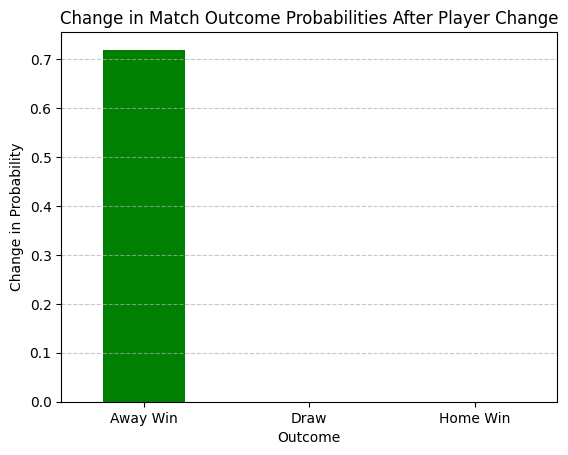

In [ ]:
player_id_to_add = 3309
player_id_to_remove = 54

original_results = simulate_match_original(home_team, away_team, attack_strength, defense_weakness, home_advantage)

adjusted_results = simulate_match_adjusted(home_team, away_team, attack_strength, defense_weakness, home_advantage, player_id_to_add, player_id_to_remove)

original_summary = original_results['outcome'].value_counts(normalize=True)
adjusted_summary = adjusted_results['outcome'].value_counts(normalize=True)

probability_changes = adjusted_summary - original_summary

print("Original probabilities:")
print(original_summary)
print("\nAdjusted probabilities:")
print(adjusted_summary)
print("\nChanges in probabilities:")
print(probability_changes)

probability_changes.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Change in Match Outcome Probabilities After Player Change')
plt.xlabel('Outcome')
plt.ylabel('Change in Probability')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


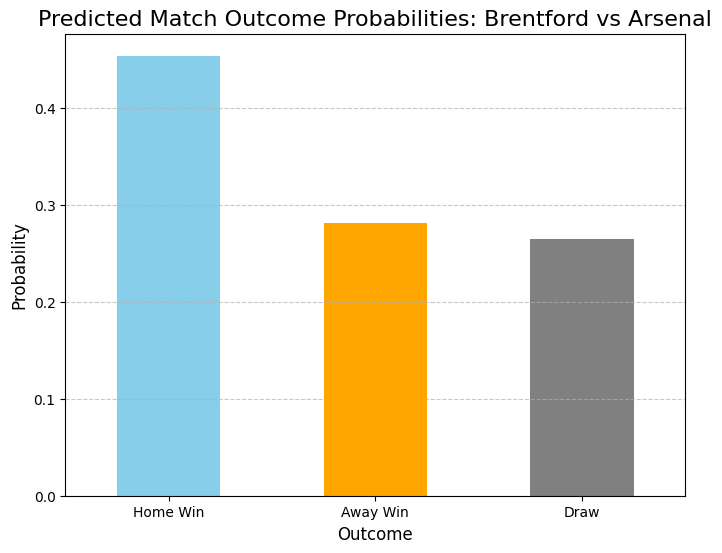

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
original_summary.plot(kind='bar', color=['skyblue', 'orange', 'gray'])
plt.title(f'Predicted Match Outcome Probabilities: {home_team_name} vs {away_team_name}', fontsize=16)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

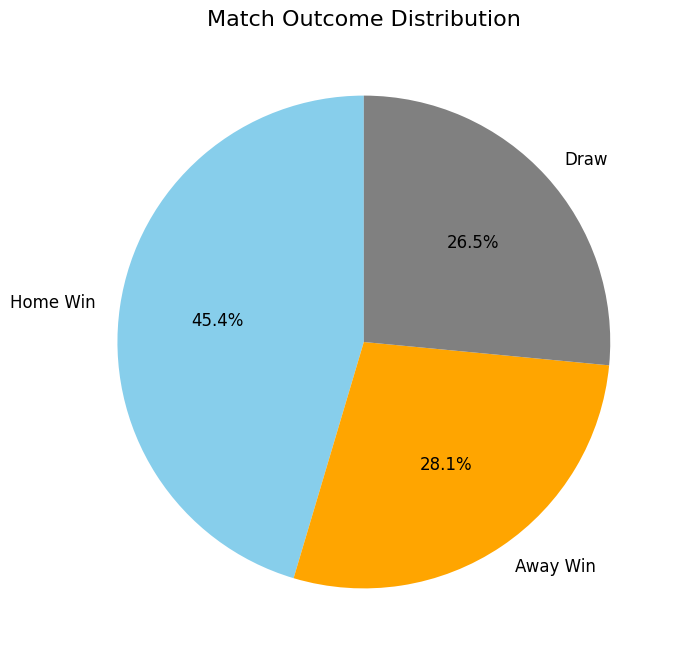

In [ ]:
plt.figure(figsize=(8, 8))
original_summary.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange', 'gray'], fontsize=12)
plt.title('Match Outcome Distribution', fontsize=16)
plt.ylabel('')
plt.show()

Porazdelitev doseženih golov na podlagi simulacij

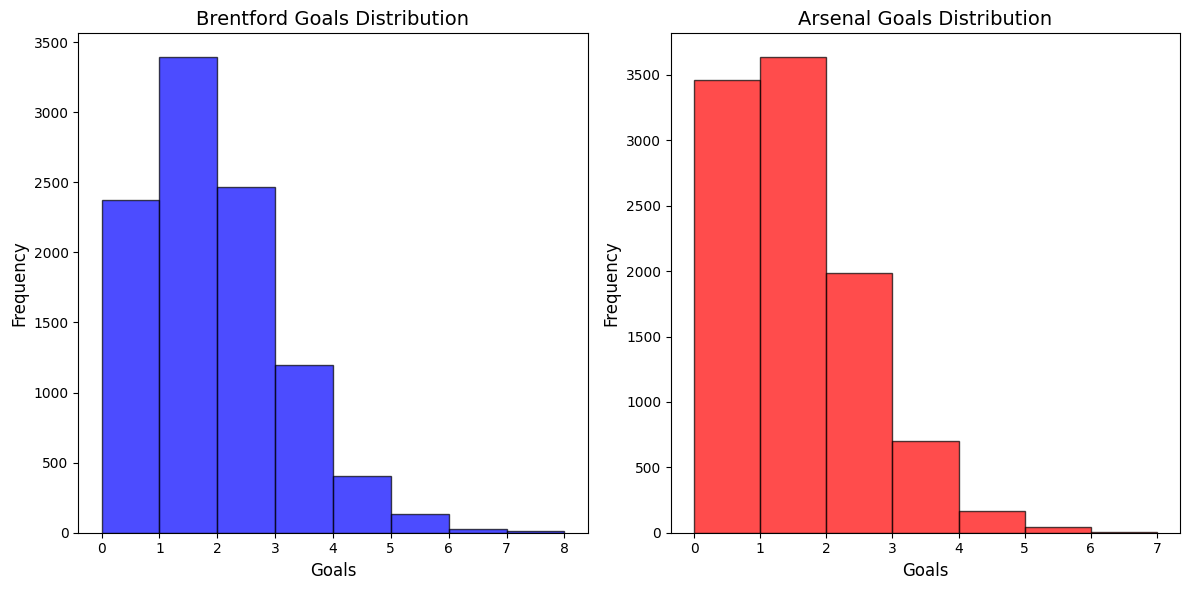

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(original_results['home_goals'], bins=range(0, max(original_results['home_goals']) + 1), alpha=0.7, color='blue', edgecolor='black')
plt.title(f'{home_team_name} Goals Distribution', fontsize=14)
plt.xlabel('Goals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1, 2, 2)
plt.hist(original_results['away_goals'], bins=range(0, max(original_results['away_goals']) + 1), alpha=0.7, color='red', edgecolor='black')
plt.title(f'{away_team_name} Goals Distribution', fontsize=14)
plt.xlabel('Goals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

Porazdelitev rezultatov tekem na podlagi števila doseženih golov domače in gostujoče ekipe.

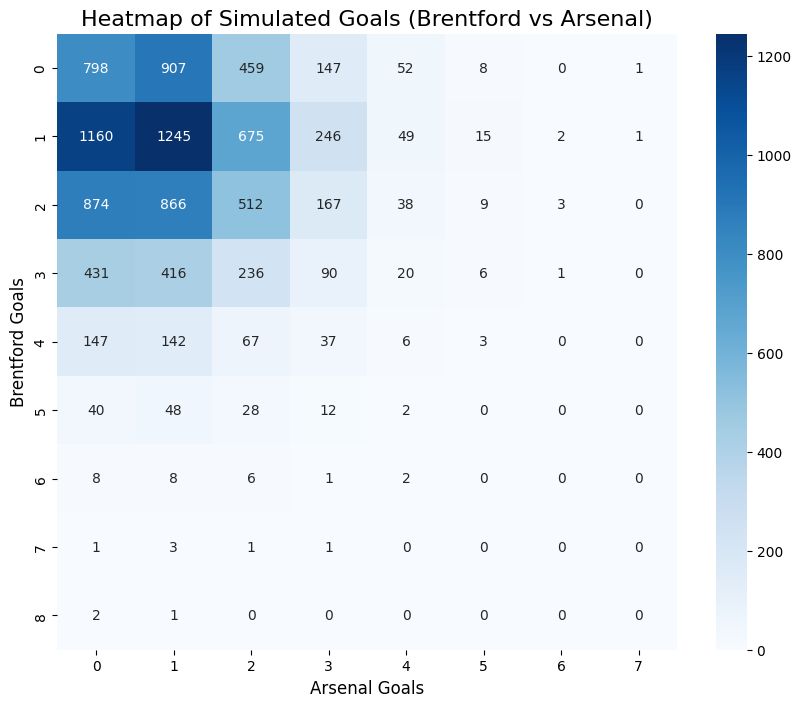

In [ ]:
import seaborn as sns

goals_pivot = original_results.groupby(['home_goals', 'away_goals']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(goals_pivot, annot=True, fmt="d", cmap='Blues', cbar=True)
plt.title(f'Heatmap of Simulated Goals ({home_team_name} vs {away_team_name})', fontsize=16)
plt.xlabel(f'{away_team_name} Goals', fontsize=12)
plt.ylabel(f'{home_team_name} Goals', fontsize=12)
plt.show()